In [98]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif', size=18)


GRIEVANCE_THRESHOLD = 0.5   # Arbitrary
N_STUDENTS          = 5000 # Consider a system with 5,000 students

# Set the time interval over which the students, discourse, and
# university update themselves
student_timestep    = 2
discourse_timestep  = 1
university_timestep = 10

# Maximum time to run for
TIME_LIMIT = 500

Explanation of student class

In [89]:
class Student(object):
    
    def __init__(self, hardship_base, tuition_value, dev_value):
        """
        Create the student
        """
        self.paying        = True           # whether or not student is attending university
        
        self.hardship_base = hardship_base  # represents class background
        self.tuition_value = tuition_value  # represents value placed on low tuition
        self.dev_value     = dev_value      # represents value based on university development
        
        self.hardship   = 0  # represents total experienced hardship
        self.legitimacy = 1  # represents perceived legitimacy of university
        self.grievance  = 0  # represents total unhappiness with university
    
    def update(self, university, discourse):
        """
        Update the Student's parameters to reflect changes in tuition and discourse
        
        @params
            university - the University object this student is part of
            discourse  - the Discourse object this student is part of
        """
        # Hardship is just base hardship from wealthyness + cost of school
        self.hardship   = self.hardship_base + university.tuition
        
        # Legitimacy comes from the discourse that the student partakes in
        self.legitimacy = discourse.legitimacy
        
        # Grievance comes from how bad things are modified by how legitimate
        # the student perceives the university to be
        self.grievance  = self.hardship * (1 - self.legitimacy)
    
    
    def consider_payment(self):
        """
        If the grievance is greater than a threshold, drop out
        """
        if self.grievance > GRIEVANCE_THRESHOLD:
            self.paying = False
        else:
            self.paying = True
            

Explanation of discourse class

In [90]:
class Discourse(object):
    
    def __init__(self):
        """
        Create the discourse
        """
        self.legitimacy = 1 
    
    def update(self, students, university):
        """
        Update the discourse to represent tuition changes
        
        legitimacy is the average of the students value of development * amount of development
        plus the students value of tuition (always negative) * tuition amount
        
        So more development usually means more legitimacy, and more tuition usually means less. 
        
        @params
            students   - a list of Student objects
            university - the University object being attended
        """
        self.legitimacy = np.mean([(student.dev_value       * university.development 
                                    + student.tuition_value * university.tuition    ) for student in students])
        
    

Explanation of University

In [91]:
class University(object):
    
    def __init__(self):
        """
        Create the university
        """
        self.tuition           = 0
        self.development       = 0
        self.revenue_threshold = 0
        
        self.revenue = None
    
    def update(self, students):
        """
        Update the university to represent changes in number of students
        
        @params
            students   - a list of Student objects
        """
        n_paying_students = np.sum([int(student.paying) for student in students])
        
        self.revenue = self.tuition * n_paying_students
    
    def consider_tuition(self):
        """
        Consider whether the university either raises tuition or develops itself a bit
        """
        
        # If the revenue is less than the preferred amount, raise tuition
        if self.revenue < self.revenue_threshold:
            self.tuition    = self.tuition + 0.01
            
        # Otherwise, develop the university and increase operating costs
        # by a little bit. Will need to tune these numbers. 
        else:
            self.development       = self.development + 0.01
            self.revenue_threshold = self.revenue_threshold + N_STUDENTS * 0.01      
        

Explanation of instantiation code

Basically, this should reflect the class stratification of the University. 
    We have students from rich families that basically like neoliberalism and think the development is well worth the cost of raised tuition.
    We have poor students that don't care at all. 
    We have international students who represent specific classes internationally. 
    We have students who will experience different sides of the university -i.e. STEM versus humanities. For whom "development" means budget cuts.
    
Currently all of these dynamics are not modeled, but may come in here where different student populations have different parameter statistics

In [92]:
# Instantiate the student population
students = []
for i in range(N_STUDENTS):
    
    # Create a hardship base from a normal distribution between 0 and 1
    hardship_base = np.random.rand(1) 
    
    # Create tuition value between 0 and -1 (i.e. tuition is always bad)
    # Create development value between -0.1 and 0.4 (i.e. development is usually good)
    tuition_value = -1*np.random.rand(1)
    dev_value     =  0.5*np.random.rand(1) - 0.1
    
    students.append(Student(hardship_base, tuition_value, dev_value))

Discourse instantiation
Multiple discourses maybe???

In [93]:
# Instantiate the discourse

discourse = Discourse()

# Instantiate the university

university = University()

Start the simulation

In [94]:
time = 0

n_students  = []
tuition     = []
development = []

while time < TIME_LIMIT:
    
    if time % student_timestep == 0:
        for student in students:
            student.update(university, discourse)
            student.consider_payment()
    
    if time % discourse_timestep == 0:
        discourse.update(students, university)
    
    if time % university_timestep == 0:
        university.update(students)
        university.consider_tuition()
    
    time = time + 1
    
    n_students.append(np.sum([int(student.paying) for student in students]))
    tuition.append(university.tuition)
    development.append(university.development)

Make some plots

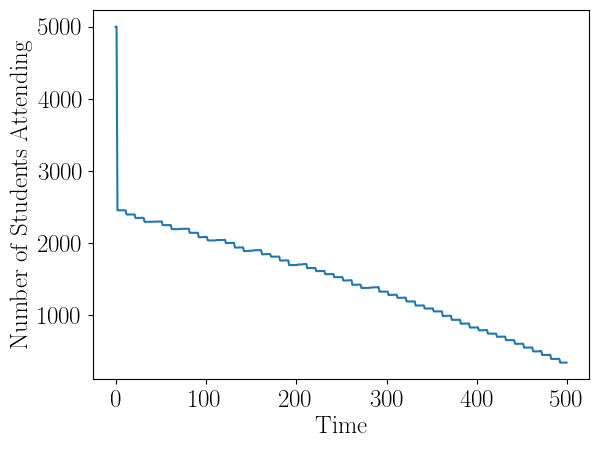

In [99]:
plt.figure()
plt.plot(np.arange(0, TIME_LIMIT, 1), n_students)
plt.xlabel("Time")
plt.ylabel("Number of Students Attending")
plt.show()

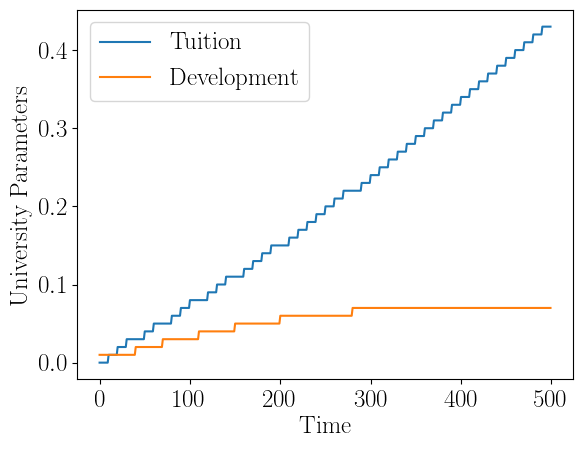

In [100]:
plt.figure()
plt.plot(np.arange(0, TIME_LIMIT, 1), tuition, label='Tuition')
plt.plot(np.arange(0, TIME_LIMIT, 1), development, label='Development')
plt.xlabel("Time")
plt.ylabel("University Parameters")
plt.legend()
plt.show()

So clearly under this system it is only a matter of time before the university fails and all students drop out, because the costs always go up (which, to be fair, they do!) 

But, even though tuition goes up, folks are willing to pay more these days than they were 50 years ago. Sounds like the tuition_value has grown closer to 0 (i.e. students dislike tuition less) - how might we model that?

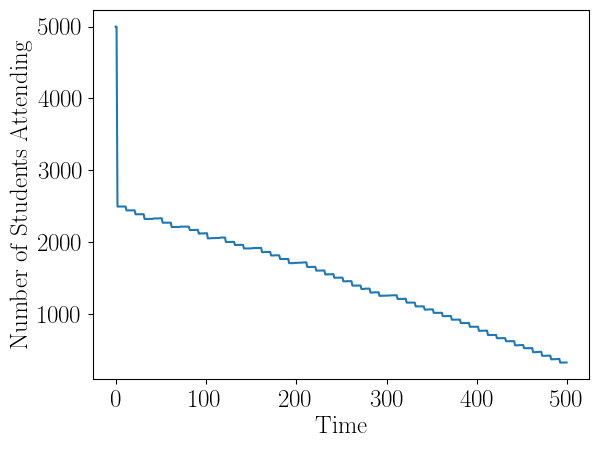

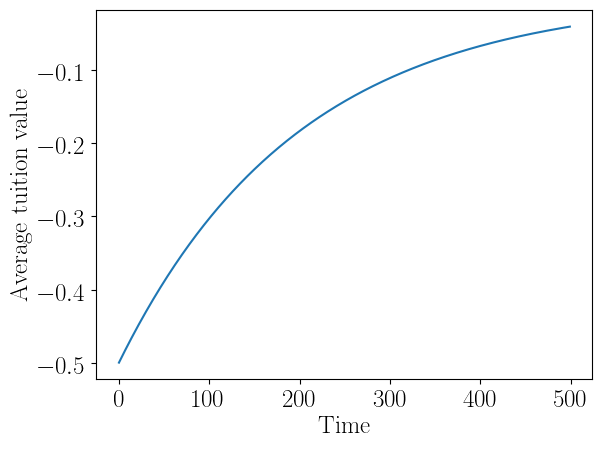

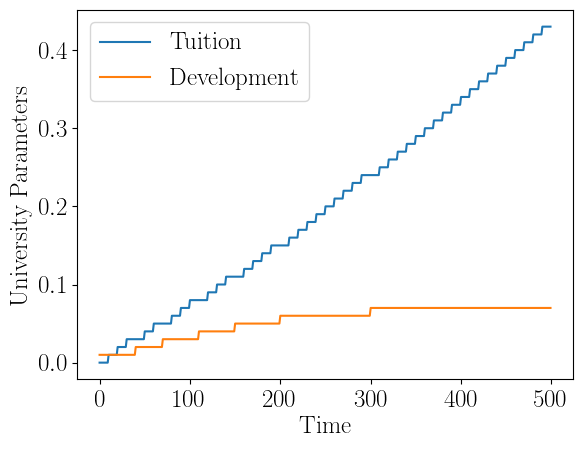

In [101]:
# Reset the population
students = []
for i in range(N_STUDENTS):
    hardship_base = np.random.rand(1) 
    tuition_value = -1*np.random.rand(1)
    dev_value     =  0.5*np.random.rand(1) - 0.1
    students.append(Student(hardship_base, tuition_value, dev_value))
university = University()
discourse  = Discourse()

time = 0

n_students  = []
tuition     = []
development = []
tuition_value_avg = []

while time < TIME_LIMIT:
    
    if time % student_timestep == 0:
        for student in students:
            student.update(university, discourse)
            student.consider_payment()
    
    if time % discourse_timestep == 0:
        discourse.update(students, university)
        
        # Here we decrease the magnitude of tuition value a little bit each discourse step
        for student in students:
            student.tuition_value = student.tuition_value * 0.995
    
    if time % university_timestep == 0:
        university.update(students)
        university.consider_tuition()
    
    time = time + 1
    
    tuition_value_avg.append(np.mean([student.tuition_value for student in students]))
    n_students.append(np.sum([int(student.paying) for student in students]))
    tuition.append(university.tuition)
    development.append(university.development)

plt.figure()
plt.plot(np.arange(0, TIME_LIMIT, 1), n_students)
plt.xlabel("Time")
plt.ylabel("Number of Students Attending")
plt.show()

plt.figure()
plt.plot(np.arange(0, TIME_LIMIT, 1), tuition_value_avg)
plt.xlabel("Time")
plt.ylabel("Average tuition value")
plt.show()

plt.figure()
plt.plot(np.arange(0, TIME_LIMIT, 1), tuition, label='Tuition')
plt.plot(np.arange(0, TIME_LIMIT, 1), development, label='Development')
plt.xlabel("Time")
plt.ylabel("University Parameters")
plt.legend()
plt.show()

In this schema, the university is able to raise tuition more, but it ultimately leads to the same result as before. 

A few dynamical notes
1. The development grows logarithmically while the tuition grows linearly. Therefore, even if you value development much more than you care about tuition, it will still be too much in the end. 
2. The number of students always drops - but in reality, the number of students is increasing, with student loans making up the economic difference. This might be modeled as another object class - the "economy", which can make the student base hardship more or less bad, depending on group.
3. I think this points to a fundamental question overall, which is: why are students willing to pay more under normal conditions? Because covid-19 will either challenge or not challenge that reason. 
4. I think another dynamic from covid-19 will be to decrease the "perceived" development of the university - after all, what are the buildings good for if you're taking all your classes online?